In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
import matplotlib.pyplot as plt

In [2]:
transform = Compose([
    ToTensor(),
    Normalize((0.5), (0.5)),
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

In [3]:
batch_size = 64
z_noise = 100

train_dataloader = DataLoader(training_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(torch.min(X), torch.max(X))
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
tensor(-1.) tensor(1.)


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(16, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32*3*3, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

discriminator = Discriminator().to(device)
print(discriminator)

Using cuda device
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
   

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(z_noise, 64, 7, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

generator = Generator().to(device)
print(generator)

Generator(
  (conv): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


In [6]:
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [7]:
epoch = 50

for i in range(epoch):
  print(f"Epoch {i+1}\n-------------------------------")

  discriminator.train()
  generator.train()
  for batch, (img, _) in enumerate(train_dataloader):
    img = img.to(device)

    d_optimizer.zero_grad()

    # noise = torch.randn(batch_size, z_noise).to(device)
    noise = torch.randn(batch_size, z_noise, 1, 1).to(device)
    fake_img = generator(noise)
    # fake_img = fake_img.reshape(-1, 1, 28, 28)
    d_real = discriminator(img)
    d_real_loss = loss_fn(d_real, torch.ones_like(d_real))

    d_fake = discriminator(fake_img)
    d_fake_loss = loss_fn(d_fake, torch.zeros_like(d_fake))

    d_loss = (d_real_loss + d_fake_loss) / 2

    d_real_loss.backward()
    d_fake_loss.backward()
    d_optimizer.step()


    g_optimizer.zero_grad()

    # noise = torch.randn(batch_size, z_noise).to(device)
    noise = torch.randn(batch_size, z_noise, 1, 1).to(device)
    fake_img = generator(noise)
    # fake_img = fake_img.reshape(-1, 1, 28, 28)
    d_fake = discriminator(fake_img)
    d_fake_loss = loss_fn(d_fake, torch.ones_like(d_fake))

    d_fake_loss.backward()
    g_optimizer.step()

    # if batch % 100 == 0:
    #   print(f"D loss: {d_loss:>7f}", f"G loss: {d_fake_loss:>7f}")
  print(f"D loss: {d_loss:>7f}", f"G loss: {d_fake_loss:>7f}")
print("Done!")

Epoch 1
-------------------------------
D loss: 0.086891 G loss: 2.979696
Epoch 2
-------------------------------
D loss: 0.127913 G loss: 2.677627
Epoch 3
-------------------------------
D loss: 0.110987 G loss: 3.522263
Epoch 4
-------------------------------
D loss: 0.216259 G loss: 4.347270
Epoch 5
-------------------------------
D loss: 0.108539 G loss: 5.054214
Epoch 6
-------------------------------
D loss: 0.021323 G loss: 6.462098
Epoch 7
-------------------------------
D loss: 0.032095 G loss: 6.635013
Epoch 8
-------------------------------
D loss: 0.139019 G loss: 7.399455
Epoch 9
-------------------------------
D loss: 0.018924 G loss: 6.459733
Epoch 10
-------------------------------
D loss: 0.010015 G loss: 6.017720
Epoch 11
-------------------------------
D loss: 0.030076 G loss: 4.993642
Epoch 12
-------------------------------
D loss: 0.008553 G loss: 7.569249
Epoch 13
-------------------------------
D loss: 0.041368 G loss: 5.936694
Epoch 14
-------------------------

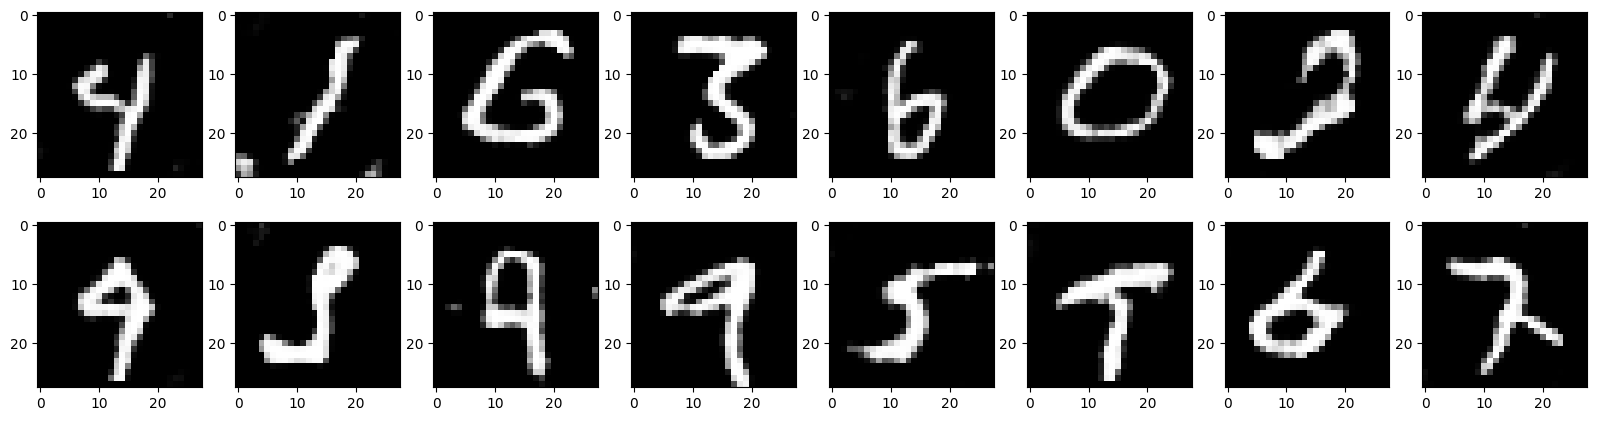

In [8]:
fig = plt.figure(figsize=(20, 5))
rows = 2
columns = 8
with torch.no_grad():
  for i in range(16):
    fig.add_subplot(rows, columns, i+1)
    # noise = torch.randn(1, z_noise).to(device)
    noise = torch.randn(1, z_noise, 1, 1).to(device)
    fake_img = generator(noise).cpu().detach()
    # fake_img = fake_img.reshape(-1,1,28,28)
    plt.imshow(fake_img[0][0].detach().numpy(), cmap="gray")